:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

# **Biotite Thermobarometer**: Pre-trained model on simulated data (ds55 with Tajcmanova biotie solution model) and fine-tuned on natural biotite composition data

This notebook is used for the "final model" fitting of a biotite thermobarometer using transfer-learing.

The "best way" of transfer was determined in ```transfer-technique.ipynb```. The results showed no significant performance improvement when using a pre-trained model. Therefore, this model is only to explore and demonastrate the potnetial differences in predictions when using a pre-trained model. Further improvements in the model performance (even tough expected to be small) are possible by optimising hyperparameters, input featrues and transfer technique.
No additional hyperparameter optimisation and feature engineering was performed.

**Data**:\
Elements [apfu] of the biotite solution models: Si, Ti, Al, Fe, Mg, Mn\
*Important*: Order of elements must be the same as in the pre-trained model!

*Normalisation*:
- Normalisation of compositional input data [-1, 1], input normalisation parameters (mean + std) are learned from the training data. **And not the original normalisation parameters from the pre-trained model are used.**
- MinMaxScaler for target data (*P*-*T*) [0, 1], target scaling parameters (min + max) are hard-coded to the range of the training data: *P* [1500, 10000] [bar] and *T* [400, 900] [°C].

**Hyperparameters**:
- Architecture: Defined by pre-trained model
- Regularisation: Dropout (0.2), proved to be crucial to avoid massive overfitting

*Parameters not systematically tested*:
- Activation function: "relu", not systematically tested, but no effect in exploratory tests
- Optimizer: "adam"
- Learning rate: 0.0005 (50% of lr for direct-fit as intital guess)
- Loss function: "mean_squared_error", given by regression task
- Lr scheduler: Inverse time decay
- Batch size: 50



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from keras.models import Model, Sequential, load_model, clone_model
from keras.layers import Dense, Normalization, Input, Dropout
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.callbacks import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T
from ml_tb.plot import plot_training_curve, prediction_vs_truth

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8516\2741006824.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import data, pre-procesing and train/test split

Validation set is **10%** of the training set. Approx. 100 samples. Validation fraction is reduced to keep the training set as large as possible. Witht the set of hyperparameters obtained by hyperparameter optimisation, overfittings should be kept to a minimum.

In [2]:
VALIDATION_FRACTION = 0.1

Global scaling parameters for MinMaxScaling of the target data are hard-coded to the range of the training data.

In [3]:
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

**IMPORTANT:** Reorder the elements in the natural data to match the order of the synthetic data!\
--> Mn and Mg are swapped in the natural data compared to the synthetic data.

In [4]:
# load excel file
data = pd.read_excel(Path("..","01_fit_natural_biotite","Metapelite-Database_Bt_CLEAN_2024-02-03.xlsx"))

biotite_composition = np.zeros(shape=(len(data), 6))
biotite_composition[:, 0] = data["Bt-Si"]
biotite_composition[:, 1] = data["Bt-Ti"]
biotite_composition[:, 2] = data["Bt-Al"]
biotite_composition[:, 3] = data["Bt-FeTot"]
biotite_composition[:, 4] = data["Bt-Mn"]
biotite_composition[:, 5] = data["Bt-Mg"]

pt = np.zeros(shape=(len(data), 2))
pt[:, 0] = data["Pressure estimate random uniform"] * 1000 # convert to bar
pt[:, 1] = data["Temperature random ordered after Ti-in-Bt"]

# check for NaN values (should be already filtered out)
print("NaN values in biotite composition: ", np.isnan(biotite_composition).any())
print("NaN values in PT: ", np.isnan(pt).any())

NaN values in biotite composition:  False
NaN values in PT:  False


In [5]:
# test train split
data_train, data_val, pt_train, pt_val = train_test_split(biotite_composition, pt, test_size=VALIDATION_FRACTION, shuffle=True)

# NORMALISATION
normalisation_biotite_composition = Normalization(axis=-1)
normalisation_biotite_composition.adapt(data_train)

print(normalisation_biotite_composition.mean.numpy())
print(np.sqrt(normalisation_biotite_composition.variance.numpy()))

# SCALING of PT
pt_train_norm = scaling_pt(pt_train)
pt_val_norm = scaling_pt(pt_val)

print("After scaling, the minimal values of P and T are: ", np.min(pt_train_norm, axis=0))
print("After scaling, the maximal values of P and T are: ", np.max(pt_train_norm, axis=0))

[[2.7077563  0.12095587 1.7102442  1.2294012  0.0084743  1.0901366 ]]
[[0.04761481 0.04806445 0.09426427 0.23239449 0.00747209 0.2648514 ]]
After scaling, the minimal values of P and T are:  [0.00010304 0.00066034]
After scaling, the maximal values of P and T are:  [0.940462  0.8988128]


## Set-up global training parameters

Define a function to calculate RMSE for pressure and temperature for unscaled values to have an interpretable metric.

In [6]:
def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [7]:
BATCH_SIZE = 50
STEPS_PER_EPOCH = len(data_train) // BATCH_SIZE
MAX_EPOCHS = 5000

lr_schedule = schedules.InverseTimeDecay(0.0005, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

LOSS = MeanSquaredError()
METRICS = [MeanAbsoluteError(), RootMeanSquaredError(), RMSE_P, RMSE_T]
OPT = Adam(lr_schedule)

CALLBACKS = [CSVLogger("03a_BtThermobaromater_finetuning.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]

## Load pre-trained model

In [8]:
# load a saved model from "02_pretraining/saved_models/model_ds55Tajcmanova2009""
model_prior = load_model(Path("..","02_pretraining", "saved_models/model_ds55Tajcmanova2009"), compile=False)

### Build model

In [9]:
model_prior_c = clone_model(model_prior, input_tensors=Input(shape=(6,)))

model_fine_tune = Sequential()
model_fine_tune.add(normalisation_biotite_composition)
model_fine_tune.add(model_prior_c.layers[1])
model_fine_tune.add(Dropout(0.2))
model_fine_tune.add(model_prior_c.layers[2])
model_fine_tune.add(Dropout(0.2))
model_fine_tune.add(model_prior_c.layers[3])
model_fine_tune.add(Dropout(0.2))
model_fine_tune.add(model_prior_c.layers[4])
model_fine_tune.add(model_prior_c.layers[5])

model_fine_tune.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
model_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

### Train model

In [10]:
history = model_fine_tune.fit(data_train, pt_train_norm,
                    validation_data=(data_val, pt_val_norm),
                    batch_size=BATCH_SIZE,
                    epochs=MAX_EPOCHS,
                    callbacks=CALLBACKS)

model_fine_tune.save(Path("saved_models", "03a_BtThermobarometer_finetuning"))

Epoch 1/5000


39/39 [==============================] - 2s 10ms/step - loss: 0.0829 - mean_absolute_error: 0.2271 - root_mean_squared_error: 0.2879 - RMSE_P: 2271.6335 - RMSE_T: 144.0349 - val_loss: 0.0345 - val_mean_absolute_error: 0.1467 - val_root_mean_squared_error: 0.1858 - val_RMSE_P: 1763.1243 - val_RMSE_T: 83.8669
Epoch 2/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.0423 - mean_absolute_error: 0.1590 - root_mean_squared_error: 0.2056 - RMSE_P: 1861.2957 - RMSE_T: 93.2511 - val_loss: 0.0237 - val_mean_absolute_error: 0.1195 - val_root_mean_squared_error: 0.1539 - val_RMSE_P: 1496.4934 - val_RMSE_T: 67.9523
Epoch 3/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.0315 - mean_absolute_error: 0.1365 - root_mean_squared_error: 0.1774 - RMSE_P: 1640.6582 - RMSE_T: 78.3127 - val_loss: 0.0186 - val_mean_absolute_error: 0.1053 - val_root_mean_squared_error: 0.1364 - val_RMSE_P: 1350.7219 - val_RMSE_T: 59.2394
Epoch 4/5000
39/39 [================

INFO:tensorflow:Assets written to: saved_models\03a_BtThermobarometer_finetuning\assets


# Plot training history

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Temperature RMSE [K]'>,
        <Axes: xlabel='Epoch', ylabel='Pressure RMSE [bar]'>], dtype=object))

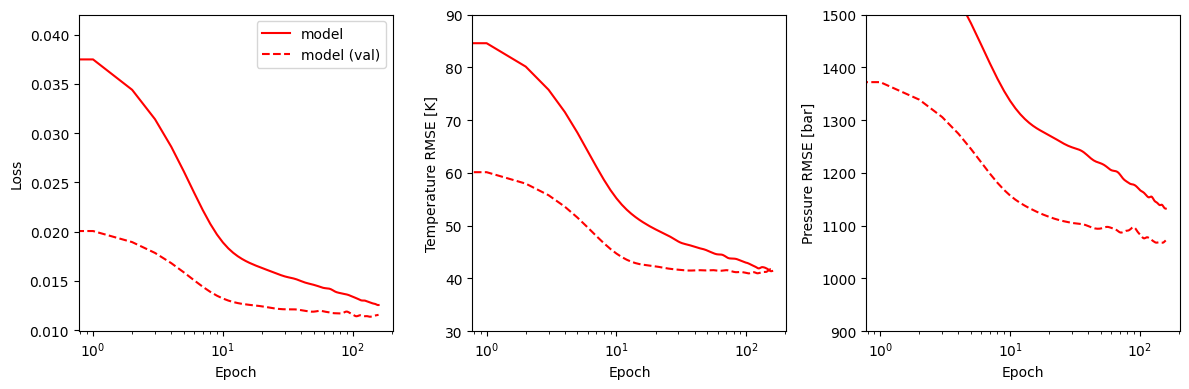

In [11]:
plot_training_curve("03a_BtThermobaromater_finetuning.log", color="red", label="model", log_scale=True, ylims=[None, (30, 90), (900, 1500)])

7/7 [==============================] - 0s 1ms/step


(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='True pressure [bar]', ylabel='Predicted pressure [bar]'>,
        <Axes: xlabel='True temperature [°C]', ylabel='Predicted temperature [°C]'>],
       dtype=object))

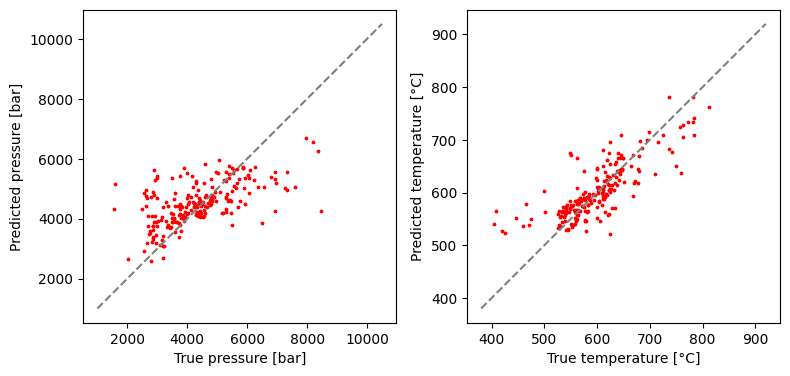

In [12]:
y_true = pt_val
y_pred = inv_scaling_pt(model_fine_tune.predict(data_val))

color = "red"

prediction_vs_truth(y_true, y_pred, color)
